In [155]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
import keras

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt


seed = 360

from datasets import make_data, train_val_test_split, tensorflow_dataset
from models import poisson_glm, mixture_poissons, mixture_poissons2
from metrics import poisson_nll, get_bpr_loss_func, get_penalized_bpr_loss_func, top_k_idx, mixture_poi_loss, get_penalized_bpr_loss_func_mix, mix_bpr
tf.config.run_functions_eagerly(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


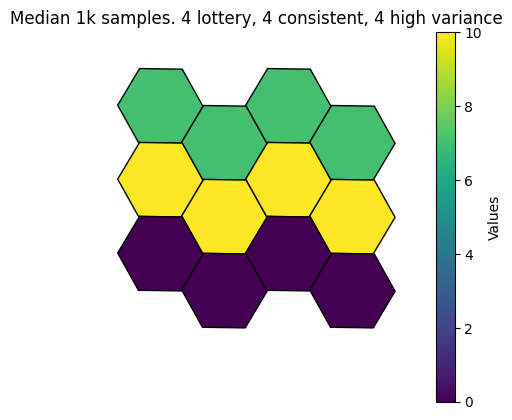

In [156]:
# tracts/distributions
S=12
# history/features
H = 50
# total timepoints
T= 500
# K for bpr
K=3

input_shape = (H,S)

consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4

sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')


X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-1, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(0, H)
    assert(np.all(X_THS[t, h, :] == y_TS[t-(H-h), :]))

(train_X_THS, train_y_TS), \
(val_X_THS, val_y_TS), \
(test_X_THS, test_y_TS) = train_val_test_split(X_THS, y_TS, train_pct=0.6, test_pct=0.2)

train_dataset = tensorflow_dataset(train_X_THS, train_y_TS, seed=seed+200,batch_size=100)
val_dataset = tensorflow_dataset(val_X_THS, val_y_TS, seed=seed+300,batch_size=100)

In [184]:
mix_model, mix_weights  = mixture_poissons(input_shape)

In [185]:
penalty = 500
bpr_threshold = 0.45

negative_bpr_K = get_bpr_loss_func(K)
penalized_bpr_loss = get_penalized_bpr_loss_func_mix(mixture_poi_loss, K, penalty, bpr_threshold)
optimizer = keras.optimizers.Adam(learning_rate=0.005)

In [186]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)

In [187]:
#mix_model.compile(optimizer=optimizer, loss=penalized_bpr_loss, metrics = [mix_bpr_metric, mixture_poi_loss])

In [188]:
preds = mix_model(train_X_THS)

In [189]:
losses = {}
losses['train'] = {}
losses['val'] ={}
losses['train']['loss']=[]
losses['train']['nll']=[]
losses['train']['bpr']=[]
losses['val']['loss']=[]
losses['val']['nll']=[]
losses['val']['bpr']=[]

In [190]:
epochs = 1000
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            y_preds = mix_model(x_batch_train, training=True)
            loss_value = penalized_bpr_loss(y_batch_train, y_preds)
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, mix_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, mix_model.trainable_weights))

    y_preds = mix_model(train_X_THS)
    loss = penalized_bpr_loss(train_y_TS, y_preds)
    loss = tf.reduce_mean(loss)
    bpr = mix_bpr(train_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
    nll = mixture_poi_loss(train_y_TS, y_preds)
    nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
    losses['train']['loss'].append(loss)
    losses['train']['nll'].append(nll)
    losses['train']['bpr'].append(bpr)
    print(loss)

    y_preds = mix_model(val_X_THS)
    loss = penalized_bpr_loss(val_y_TS, y_preds)
    loss = tf.reduce_mean(loss)
    bpr = mix_bpr(val_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
    nll = mixture_poi_loss(val_y_TS, y_preds)
    nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
    losses['val']['loss'].append(loss)
    losses['val']['nll'].append(nll)
    losses['val']['bpr'].append(bpr)
    


Start of epoch 0
tf.Tensor(144.97452, shape=(), dtype=float32)

Start of epoch 1
tf.Tensor(126.09435, shape=(), dtype=float32)

Start of epoch 2
tf.Tensor(113.60184, shape=(), dtype=float32)

Start of epoch 3
tf.Tensor(103.220764, shape=(), dtype=float32)

Start of epoch 4
tf.Tensor(92.452614, shape=(), dtype=float32)

Start of epoch 5
tf.Tensor(84.20276, shape=(), dtype=float32)

Start of epoch 6
tf.Tensor(77.76382, shape=(), dtype=float32)

Start of epoch 7
tf.Tensor(70.445526, shape=(), dtype=float32)

Start of epoch 8
tf.Tensor(64.89885, shape=(), dtype=float32)

Start of epoch 9
tf.Tensor(61.128086, shape=(), dtype=float32)

Start of epoch 10
tf.Tensor(57.336437, shape=(), dtype=float32)

Start of epoch 11
tf.Tensor(54.11233, shape=(), dtype=float32)

Start of epoch 12
tf.Tensor(50.26059, shape=(), dtype=float32)

Start of epoch 13
tf.Tensor(45.977238, shape=(), dtype=float32)

Start of epoch 14
tf.Tensor(41.86798, shape=(), dtype=float32)

Start of epoch 15
tf.Tensor(38.748657, 

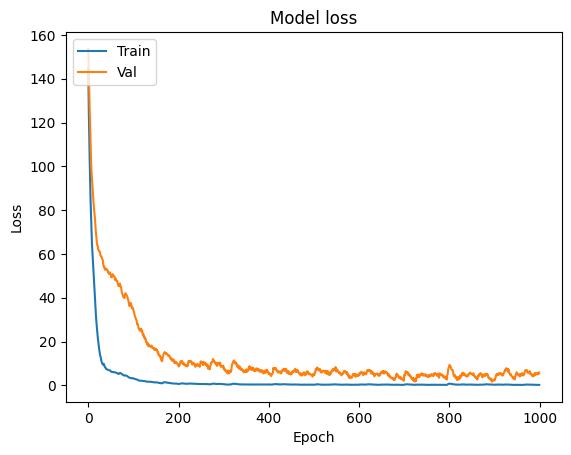

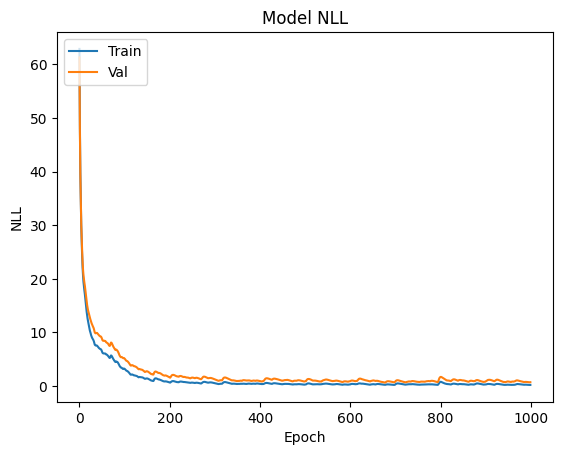

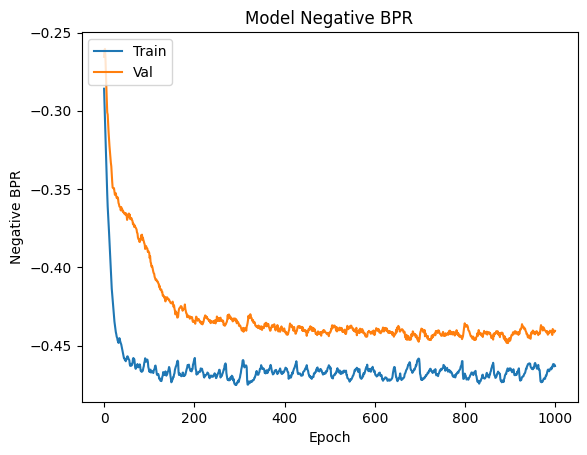

In [191]:
# plot loss and metrics from history
plt.plot(losses['train']['loss'])
plt.plot(losses['val']['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(losses['train']['nll'])
plt.plot(losses['val']['nll'])
plt.title('Model NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(losses['train']['bpr'])
plt.plot(losses['val']['bpr'])
plt.title('Model Negative BPR')
plt.ylabel('Negative BPR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [213]:
from functools import partial
val_preds, mix_weights = mix_model(val_X_THS)

mixture_weights = tf.ones((val_preds.shape[0],1)) * tf.squeeze(mix_weights)
dot_layer = keras.layers.Dot(axes=(1,-1))
mixture_pred = dot_layer([mixture_weights, val_preds])

# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(mixture_pred)
np.mean(top_K_ids, axis=0)

array([0.1 , 0.02, 0.  , 0.  , 0.58, 0.17, 0.17, 0.17, 0.42, 0.33, 0.52,
       0.52], dtype=float32)

In [205]:
mix_weights.shape

(8, 1)

In [211]:
mix_model.layers[-1](val_X_THS)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.873969  ],
       [0.12603097]], dtype=float32)>

In [212]:
mix_model(val_X_THS)

[<tf.Tensor: shape=(100, 12, 2), dtype=float32, numpy=
 array([[[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 2.1345504e-13],
         [6.4145906e-35, 1.5880117e-22]],
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 2.2063691e-36],
         [1.5347602e-32, 2.7504011e-20],
         [0.0000000e+00, 7.9896595e-37]],
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 4.9756957e-29],
         [0.0000000e+00, 0.0000000e+00],
         [4.0092460e-30, 2.4079887e-30]],
 
        ...,
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
    

In [37]:
mixture_poi_loss(train_y_TS, preds)

<tf.Tensor: shape=(300, 12), dtype=float32, numpy=
array([[3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 2.1288426e+00,
        1.4939419e+01, 7.4566450e+00],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.0016949e+01,
        9.8723297e+00, 2.3919154e-06],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.2917208e+01,
        2.9280365e+00, 9.6958210e-21],
       ...,
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 8.1487730e-02,
        2.3531229e+01, 1.3449357e+01],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.7063694e+01,
        1.0635285e+01, 5.5360909e+01],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 8.4530802e+00,
        1.9098425e+01, 2.7813427e+01]], dtype=float32)>

In [145]:
train_dataset[0]

TypeError: '_BatchDataset' object is not subscriptable